
# A/B Marketing Campaign Analysis 


We’re comparing two campaigns to answer a simple question: should we switch to the Test strategy or keep Control?

We’ll:  load → clean → sanity-check → explore → test → conclude.

### Import Modules

In [1]:
import plotly.io as pio
pio.renderers.default = "png"   
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import sys
print(sys.executable)





pio.templates.default = "plotly_white"
from IPython.display import display, Markdown

/Users/matewosberhe/Documents/Projects/ab_testing_marketing_campaign/.venv/bin/python


### Loading Data

In [3]:
control = pd.read_csv("../data/control.csv", sep=";")
test    = pd.read_csv("../data/test.csv",    sep=";")
display(Markdown("**Control (first 2 rows)**"))
display(control.head(2))

display(Markdown("**Test (first 2 rows)**"))
display(test.head(2))

**Control (first 2 rows)**

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0


**Test (first 2 rows)**

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677


### Rename columns

In [4]:
col_map = {
    "Campaign Name":        "campaign",
    "Date":                 "date",
    "Spend [USD]":          "amount_spent",
    "# of Impressions":     "impressions",
    "Reach":                "reach",
    "# of Website Clicks":  "clicks",
    "# of Searches":        "searches",
    "# of View Content":    "views",
    "# of Add to Cart":     "add_to_cart",
    "# of Purchase":        "purchases",
}

control.rename(columns=col_map, inplace=True)
test.rename(columns=col_map, inplace=True)

### Convert to datetime

In [5]:
control["date"] = pd.to_datetime(control["date"], dayfirst=True, errors="coerce")
test["date"]    = pd.to_datetime(test["date"], dayfirst=True, errors="coerce")


#### Merging Control and Test

In [6]:
data = pd.concat([control, test], axis=0).sort_values("date").reset_index(drop=True)


In [7]:
# check for missing values before imputation
data.isna().sum()

campaign        0
date            0
amount_spent    0
impressions     1
reach           1
clicks          1
searches        1
views           1
add_to_cart     1
purchases       1
dtype: int64

In [9]:
num_cols = ["amount_spent","impressions","reach","clicks",
            "searches","views","add_to_cart","purchases"]
cat_cols = ["campaign"]


for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")
    data[c] = data[c].fillna(data[c].mean()).round().astype(int)

# categorical → fill NaN with mode
for c in cat_cols:
    if data[c].isna().any():
        data[c] = data[c].fillna(data[c].mode()[0])


      

In [10]:
data[num_cols] = data[num_cols].round().astype("Int64")

In [11]:
display(data.head(2))


,campaign,date,amount_spent,impressions,reach,clicks,searches,views,add_to_cart,purchases
0,Control Campaign,2019-08-01,2280,82702,56930,7016,2290,2159,1819,618
1,Test Campaign,2019-08-01,3008,39550,35820,3038,1946,1069,894,255


In [12]:
# check again after imputation to confirm all NaNs were handled
data.isna().sum()

campaign        0
date            0
amount_spent    0
impressions     0
reach           0
clicks          0
searches        0
views           0
add_to_cart     0
purchases       0
dtype: int64

#### count duplicate rows 

In [13]:
dup_count = data.duplicated().sum()

if dup_count == 0:
    print(" No duplicate rows found in the dataset.")
else:
    print(f" Found {dup_count} duplicate rows in the dataset.")


 No duplicate rows found in the dataset.


In [14]:
data.describe()

,date,amount_spent,impressions,reach,clicks,searches,views,add_to_cart,purchases
count,60,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
mean,2019-08-15 12:00:00,2425.75,91775.883333,70868.65,5682.6,2321.816667,1900.166667,1087.216667,522.0
min,2019-08-01 00:00:00,1757.0,22521.0,10598.0,2277.0,1001.0,848.0,278.0,222.0
25%,2019-08-08 00:00:00,2073.75,69558.25,43235.5,4230.75,1970.75,1249.0,863.25,340.0
50%,2019-08-15 12:00:00,2420.5,95448.5,75205.5,5687.0,2374.5,1937.5,1081.0,506.0
75%,2019-08-23 00:00:00,2727.5,117160.5,95314.25,7201.25,2755.75,2422.5,1384.25,685.0
max,2019-08-30 00:00:00,3112.0,145248.0,127852.0,8264.0,4891.0,4219.0,1913.0,890.0
std,NaN,381.130461,32188.767138,30759.61762,1739.843011,663.34651,681.414684,426.54386,195.297513


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   campaign      60 non-null     object        
 1   date          60 non-null     datetime64[ns]
 2   amount_spent  60 non-null     Int64         
 3   impressions   60 non-null     Int64         
 4   reach         60 non-null     Int64         
 5   clicks        60 non-null     Int64         
 6   searches      60 non-null     Int64         
 7   views         60 non-null     Int64         
 8   add_to_cart   60 non-null     Int64         
 9   purchases     60 non-null     Int64         
dtypes: Int64(8), datetime64[ns](1), object(1)
memory usage: 5.3+ KB


##### Sanity check

In [16]:

print("clicks ≤ impressions:", bool((data["clicks"] <= data["impressions"]).all()))
print("purchases ≤ clicks:",   bool((data["purchases"] <= data["clicks"]).all()))
print("reach ≤ impressions:",  bool((data["reach"] <= data["impressions"]).all()))
data["campaign"].value_counts()


clicks ≤ impressions: True
purchases ≤ clicks: True
reach ≤ impressions: True


campaign
Control Campaign    30
Test Campaign       30
Name: count, dtype: int64

In [18]:
aligned = data.copy()


# add CTR and CR to `aligned` (safe for zeros)
aligned["ctr"] = np.where(aligned["impressions"] > 0,
                          aligned["clicks"] / aligned["impressions"],
                          np.nan)

aligned["cr"]  = np.where(aligned["reach"] > 0,
                          aligned["purchases"] / aligned["reach"],
                          np.nan)

# quick sanity check
print(aligned[["date","campaign","clicks","impressions","purchases","reach","ctr","cr"]].head())


        date          campaign  clicks  impressions  purchases   reach  \
0 2019-08-01  Control Campaign    7016        82702        618   56930   
1 2019-08-01     Test Campaign    3038        39550        255   35820   
2 2019-08-02  Control Campaign    8110       121040        511  102513   
3 2019-08-02     Test Campaign    4657       100719        677   91236   
4 2019-08-03  Control Campaign    6508       131711        372  110862   

        ctr        cr  
0  0.084835  0.010855  
1  0.076814  0.007119  
2  0.067003  0.004985  
3  0.046238  0.007420  
4  0.049411  0.003356  


In [19]:
import kaleido
print("Kaleido is working!")


Kaleido is working!


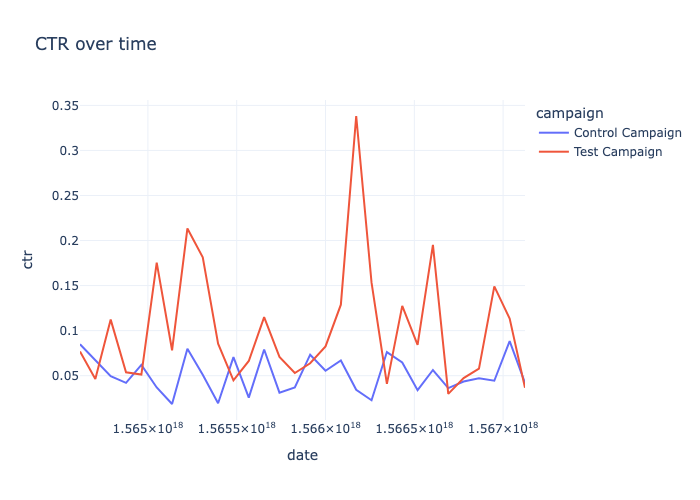

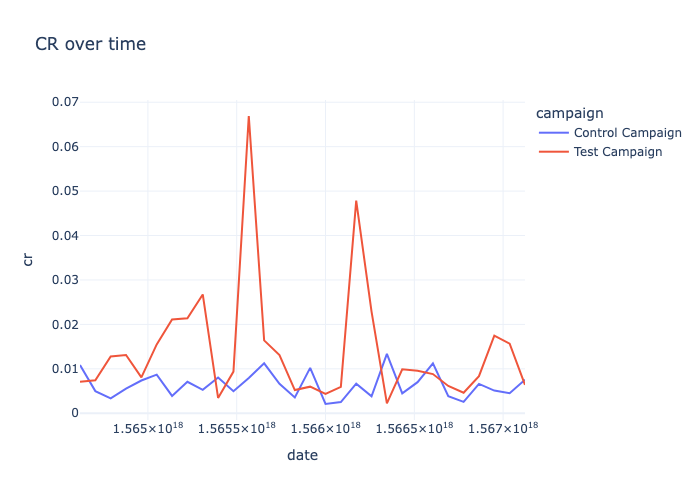

In [20]:
px.line(aligned, x="date", y="ctr", color="campaign", title="CTR over time").show()
px.line(aligned, x="date", y="cr",  color="campaign", title="CR over time").show()


In [21]:
# Aggregate once at the campaign level 
summary = (aligned
           .groupby("campaign", as_index=False)[
               ["amount_spent","impressions","reach","clicks","purchases"]
           ].sum())

# Rates from totals + CAC
summary["ctr"] = summary["clicks"] / summary["impressions"]
summary["cr"]  = summary["purchases"] / summary["reach"]
summary["cac"] = summary["amount_spent"] / summary["purchases"]

summary.round(4)


,campaign,amount_spent,impressions,reach,clicks,purchases,ctr,cr,cac
0,Control Campaign,68653,3269009,2647372,159986,15683,0.0489,0.0059,4.3775
1,Test Campaign,76892,2237544,1604747,180970,15637,0.0809,0.0097,4.9173


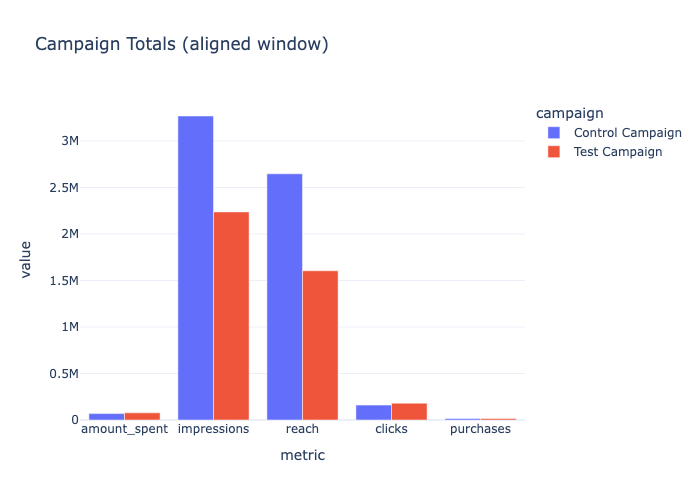

In [22]:
totals_long = summary.melt(
    id_vars="campaign",
    value_vars=["amount_spent","impressions","reach","clicks","purchases"],
    var_name="metric",
    value_name="value"
)
px.bar(
    totals_long, x="metric", y="value", color="campaign", barmode="group",
    title="Campaign Totals (aligned window)"
).show()



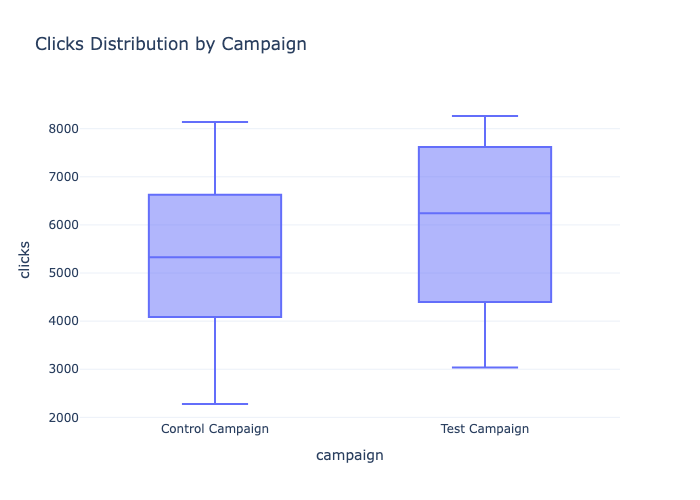

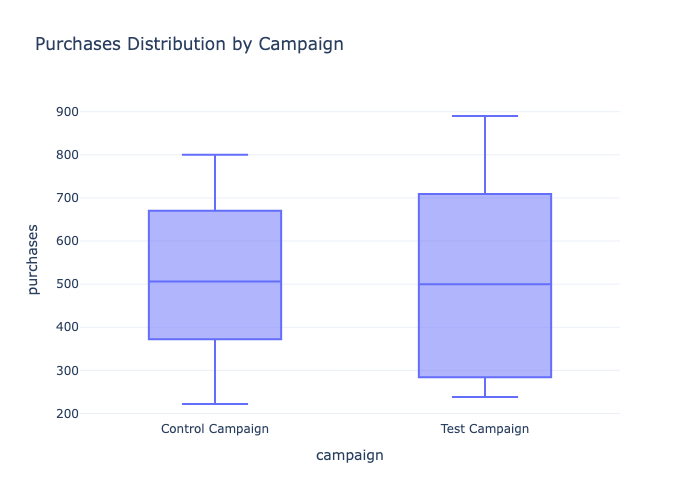

In [23]:
px.box(aligned, x="campaign", y="clicks", points="outliers",
       title="Clicks Distribution by Campaign").show()

px.box(aligned, x="campaign", y="purchases", points="outliers",
       title="Purchases Distribution by Campaign").show()


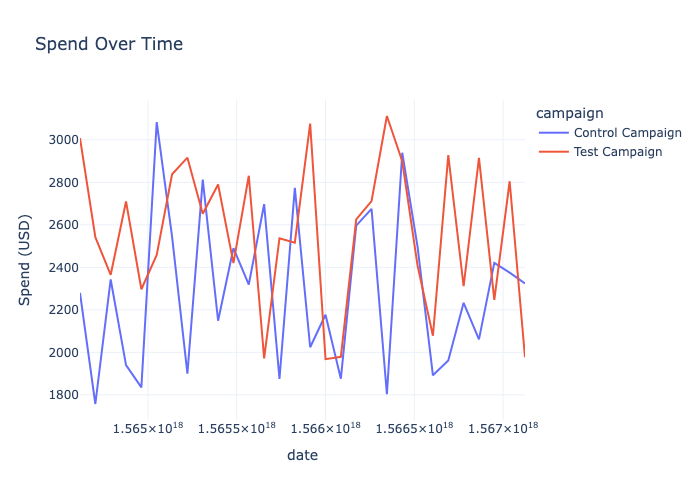

In [24]:

px.line(
    aligned, x="date", y="amount_spent", color="campaign",
    title="Spend Over Time", labels={"amount_spent":"Spend (USD)"}
).show()


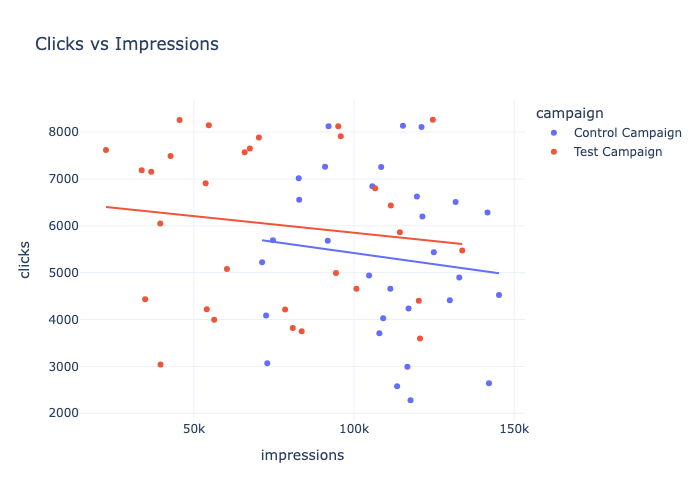

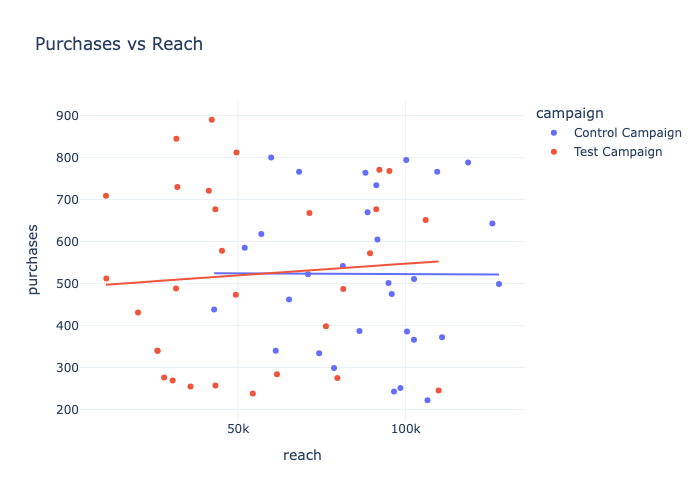

In [25]:
px.scatter(aligned, x="impressions", y="clicks", color="campaign",
           trendline="ols", title="Clicks vs Impressions").show()

px.scatter(aligned, x="reach", y="purchases", color="campaign",
           trendline="ols", title="Purchases vs Reach").show()


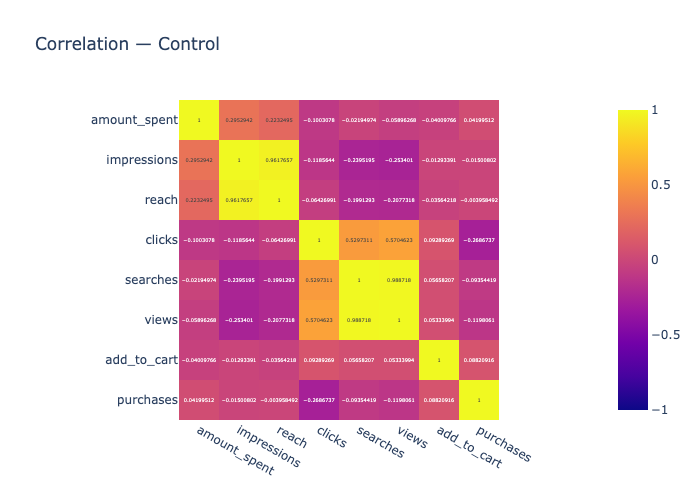

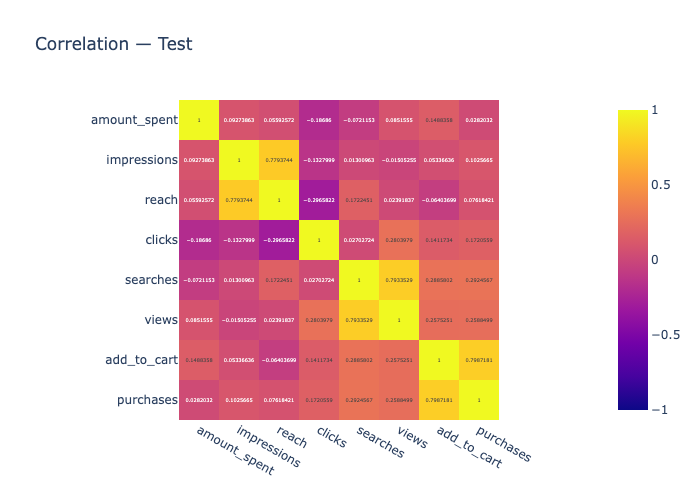

In [26]:

num_cols = ["amount_spent","impressions","reach","clicks",
            "searches","views","add_to_cart","purchases"]

# split by campaign and compute correlations
corr_control = aligned.loc[aligned["campaign"].str.contains("Control", case=False), num_cols].corr()
corr_test    = aligned.loc[aligned["campaign"].str.contains("Test",    case=False), num_cols].corr()

# heatmaps
fig1 = px.imshow(corr_control, text_auto=True, zmin=-1, zmax=1, title="Correlation — Control")
fig2 = px.imshow(corr_test,    text_auto=True, zmin=-1, zmax=1, title="Correlation — Test")
fig1.show(); fig2.show()


In [28]:

# grab rows regardless of exact label text
c = summary.loc[summary["campaign"].str.contains("Control", case=False)].squeeze()
t = summary.loc[summary["campaign"].str.contains("Test", case=False)].squeeze()

# --- z-tests on totals (correct denominators) ---
# CTR: clicks / impressions
z_ctr, p_ctr = proportions_ztest(
    count=[int(t["clicks"]), int(c["clicks"])],
    nobs =[int(t["impressions"]), int(c["impressions"])]
)

# CR: purchases / reach
z_cr, p_cr = proportions_ztest(
    count=[int(t["purchases"]), int(c["purchases"])],
    nobs =[int(t["reach"]),      int(c["reach"])]
)

In [30]:
# 95% CIs for each group (Wald, to match z-test)
ci_ctr_c = proportion_confint(int(c["clicks"]),    int(c["impressions"]), method="normal")
ci_ctr_t = proportion_confint(int(t["clicks"]),    int(t["impressions"]), method="normal")
ci_cr_c  = proportion_confint(int(c["purchases"]), int(c["reach"]),       method="normal")
ci_cr_t  = proportion_confint(int(t["purchases"]), int(t["reach"]),       method="normal")

# lifts (relative)
ctr_c, ctr_t = c["ctr"], t["ctr"]
cr_c,  cr_t  = c["cr"],  t["cr"]
lift_ctr_pct = 100 * (ctr_t - ctr_c) / ctr_c
lift_cr_pct  = 100 * (cr_t  - cr_c)  / cr_c

print("Results (totals-based)")
print(f"CTR: p={p_ctr:.4f} | Control CI={tuple(round(x,4) for x in ci_ctr_c)} | Test CI={tuple(round(x,4) for x in ci_ctr_t)} | Lift={lift_ctr_pct:.2f}%")
print(f"CR : p={p_cr:.4f}  | Control CI={tuple(round(x,4) for x in ci_cr_c)}  | Test CI={tuple(round(x,4) for x in ci_cr_t)}  | Lift={lift_cr_pct:.2f}%")

print("\nVerdict:")
print("• CTR difference is " + ("statistically significant " if p_ctr < 0.05 else "not significant "))
print("• CR  difference is " + ("statistically significant " if p_cr  < 0.05 else "not significant "))



Results (totals-based)
CTR: p=0.0000 | Control CI=(0.0487, 0.0492) | Test CI=(0.0805, 0.0812) | Lift=65.26%
CR : p=0.0000  | Control CI=(0.0058, 0.006)  | Test CI=(0.0096, 0.0099)  | Lift=64.49%

Verdict:
• CTR difference is statistically significant 
• CR  difference is statistically significant 


In [32]:
# grab rows (works with "Control" or "Control Campaign")
c, t = [summary.loc[summary["campaign"].str.contains(k, case=False)].squeeze()
        for k in ("Control","Test")]

# rates from totals
ctr_c, ctr_t = c["clicks"]/c["impressions"], t["clicks"]/t["impressions"]
cr_c,  cr_t  = c["purchases"]/c["reach"],    t["purchases"]/t["reach"]

# two-proportion z-tests
_, p_ctr = proportions_ztest(list(map(int,[t["clicks"],     c["clicks"]])),
                             list(map(int,[t["impressions"],c["impressions"]])))
_, p_cr  = proportions_ztest(list(map(int,[t["purchases"],  c["purchases"]])),
                             list(map(int,[t["reach"],      c["reach"]])))

# report (pretty)
rep = pd.DataFrame({
    "metric":   ["CTR","CR"],
    "control":  [ctr_c, cr_c],
    "test":     [ctr_t, cr_t],
    "lift_%":   [100*(ctr_t-ctr_c)/ctr_c, 100*(cr_t-cr_c)/cr_c],
    "p_value":  [p_ctr, p_cr],
})
rep["control"] = (rep["control"]*100).round(2).astype(str)+"%"
rep["test"]    = (rep["test"]*100).round(2).astype(str)+"%"
rep["lift_%"]  = rep["lift_%"].round(2).astype(str)+"%"
rep["p_value"] = rep["p_value"].apply(lambda p: "<0.001" if p<1e-3 else f"{p:.3f}")

display(rep)



,metric,control,test,lift_%,p_value
0,CTR,4.89%,8.09%,65.26%,<0.001
1,CR,0.59%,0.97%,64.49%,<0.001


In [33]:
if (p_ctr < 0.05 and p_cr < 0.05):
    decision = ("\nOur analysis indicates the Test campaign is performing better, "
                "with significantly more clicks and purchases than Control.\n "
                "This suggests it influences user behavior effectively. "
                "However, note that costs and other unmeasured factors should also be considered.")
else:
    decision = ("\nThe results are mixed or not statistically significant. "
                "Interpret with caution, and consider additional metrics before deciding.")
print("Decision:", decision)


Decision: 
Our analysis indicates the Test campaign is performing better, with significantly more clicks and purchases than Control.
 This suggests it influences user behavior effectively. However, note that costs and other unmeasured factors should also be considered.
